# monte carlo simulation

In [128]:
def bsm_call_value(S0,K,T,r,sigma):
    from math import log,sqrt,exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K ) + (r + 0.5 * sigma ** 2) * T) /(sigma * sqrt(T))
    d2 = (log(S0 / K ) + (r - 0.5 * sigma ** 2) * T) /(sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1,0.0,1.0)
            - K * exp(-r * T) * stats.norm.cdf(d2,0.0,1.0))
    return value

def bsm_vega(S0,K,T,r,sigma):
    from math import log,sqrt
    from scipy import stats 
    S0 = float(S0)
    d1 = (log(S0 / K ) + (r + 0.5 * sigma ** 2) * T) /(sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1,0.0,1.0) * sqrt(T)

    return vega

def bsm_implied_volatility(S0,K,T,r,C0,sigma_est, it= 100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0,K,T,r,sigma_est) - C0)
                     / bsm_vega(S0,K,T,r,sigma_est))
    return sigma_est

In [129]:
bsm_call_value(100,105,1.0,0.05,0.2)

8.021352235143176

### pure python

In [115]:
from time import time
from math import exp, sqrt, log
from random import gauss, seed

In [116]:
seed(20000)

In [117]:
# t0 = time()

In [120]:
S0 = 100 # initial value
K = 105 # strike price
T = 1.0 # maturity
r = 0.05 # riskless short rate
sigma = 0.2 # volatility
M = 50 # number of time steps
dt = T/M #length of time interval
I = 250000 # number of paths

In [123]:
S = [] # 空のリスト作成
for i in range(I):# i=Iまで繰り返し
    path = [] # 空のリスト作成
    for t in range (M+1):#時間に関する繰り返し。この場合はM（満期）まで。
        if t == 0: 
            path.append(S0) # t=0の時は、初期値S0をpathリストに加える
        else:
            z = gauss(0.0,1.0) #zを標準正規分布に従う乱数とする
            St = path[t-1]*exp((r-0.5*sigma**2)*dt+sigma*sqrt(dt)*z) #Stをオイラー法（3.6式）によって求める
            path.append(St) #求まったStをpathに加える。
    S.append(path) # pathをSリストに加える

In [124]:
# monte carlo estimatorを回す

C0 = exp(-r*T)*sum([max(path[-1]-K,0) for path in S])/I # 3.7式より、monte carlo estimatorを計算。

In [125]:
C0

8.022585940104033

In [28]:
#結果の確認

# tpy = time()-t0
# print("European Option Value %7.3f"%C0)
# print("Duration in Seconds %7.3f"%tpy)

European Option Value   8.037
Duration in Seconds 1368.131


In [132]:
# 関数にしたバージョン（中身は同じ）

def simple_MC(): 
    
    S = []
    for i in range(I):
        path = []
        for t in range(M+1):
            if t == 0:
                path.append(S0)
            else:
                z = gauss(0.0,1.0)
                St = path[t - 1] * exp((r - 0.5 * sigma ** 2) * dt
                                        + sigma * sqrt(dt) * z)
                path.append(St)
        S.append(path)
        
    C0 = exp(-r * T ) * sum([max(path[-1] - K,0) for path in S]) / I
    # tpy  = time() - t0
    
    print ("european otion value %7.3f" % C0)
    
    # print ("duration is sec %7.3f" % tpy)



In [138]:
%%time
simple_MC()

european otion value   8.048
CPU times: user 53.3 s, sys: 3.4 s, total: 56.7 s
Wall time: 57.5 s


In [103]:
# for loopをうまく用いて、より効率的に書くこともできる。
sum_val = 0.0
for path in S:
    # C-like iteration for comparison
    sum_val += max(path[-1] - K, 0)
C0 = exp(-r * T) * sum_val / I
round(C0, 3)

8.037

### vectorization with Numpy

In [73]:
import numpy as np
v = np.arange(1,6)
v

array([1, 2, 3, 4, 5])

In [74]:
2*v

array([ 2,  4,  6,  8, 10])

In [136]:
# numpyを用いたmonte carlo valuation

import numpy as np
import math
from time import time

def vector_MC():
    S = np.zeros((M+1,I)) #SをM+1行 I列の零行列とする
    S[0] = S0 # Sの1要素目をS0とする
    
    for t in range(1,M+1): #時間に関する繰り返し。この場合はM（満期）まで。
        z = np.random.standard_normal(I) # 標準正規分布に従う乱数
        S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z) # Stをオイラー法によって求める　　
        
    C0 = math.exp(-r*T)*np.sum(np.maximum(S[-1]-K,0))/I
    # tmp = time()-t0
        
    print ("european otion value %7.3f" % C0)
    # print ("duration is sec %7.3f" % tmp)

In [137]:
%%time
vector_MC()

european otion value   8.029
CPU times: user 612 ms, sys: 47 ms, total: 659 ms
Wall time: 659 ms


### Full Vectorization with Log Euler Scheme

In [139]:
from numpy import *

# for loopなしでmonte carloを回すことができる。 t=Tまでの累積和で表現。これは対数オイラー法と同値。

def full_vector_MC():
    
    S = np.zeros((M+1,I))
    S[0] = S0
    S = S0 * exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt)* np.random.standard_normal((M+1,I)),axis=0)) # オイラー方のtについて累積和を取っている。　　　　　
    
    C0 = math.exp(-r * T) * sum(maximum(S[-1] - K,0)) / I    
    # tmp2 = time() - t0
    
    print ("european otion value %7.3f" % C0)
    # print ("duration is sec %7.3f" % tmp2)


In [140]:
%%time
full_vector_MC()

european otion value   8.153
CPU times: user 793 ms, sys: 152 ms, total: 945 ms
Wall time: 966 ms


### Graphical Analysis

In [145]:
import matplotlib.pyplot as plt

# 全期間、パス10こ

def visualize_MC_1():
    S = np.zeros((M+1,I)) #SをM+1行 I列の零行列とする
    S[0] = S0 # Sの1要素目をS0とする
    
    for t in range(1,M+1): #時間に関する繰り返し。この場合はM（満期）まで。
        z = np.random.standard_normal(I) # 標準正規分布に従う乱数
        S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z) # Stをオイラー法によって求める　　
    plt.plot(S[:,:10])
    plt.grid(True)
    plt.xlabel('time step')
    plt.ylabel('index level')
    #plt.ylim(50,150)

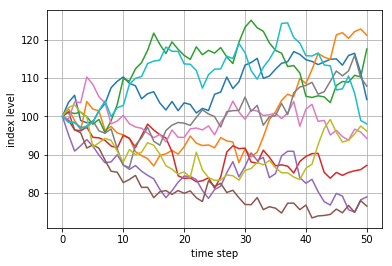

In [146]:
visualize_MC_1()

In [149]:
#満期でのindex level velues (ST) の分布を見る。

def vector_MC_2():
    S = np.zeros((M+1,I)) #SをM+1行 I列の零行列とする
    S[0] = S0 # Sの1要素目をS0とする
    
    for t in range(1,M+1): #時間に関する繰り返し。この場合はM（満期）まで。
        z = np.random.standard_normal(I) # 標準正規分布に従う乱数
        S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z) # Stをオイラー法によって求める　　
        
    plt.hist(S[-1],bins = 50) # bins:ビン数（そのまま笑）
    plt.grid(True)
    plt.xlabel('index level')
    plt.ylabel('frequency')

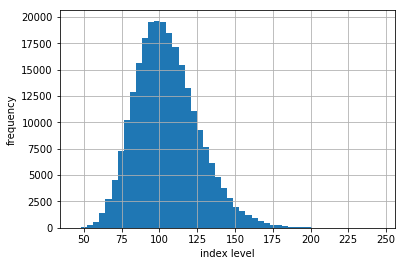

In [150]:
vector_MC_2()

In [151]:
# 満期でのinner value の分布を見てみる。

def vector_MC_3():
    S = np.zeros((M+1,I)) #SをM+1行 I列の零行列とする
    S[0] = S0 # Sの1要素目をS0とする
    
    for t in range(1,M+1): #時間に関する繰り返し。この場合はM（満期）まで。
        z = np.random.standard_normal(I) # 標準正規分布に従う乱数
        S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt+sigma*math.sqrt(dt)*z) # Stをオイラー法によって求める　　
        
    plt.hist(np.maximum(S[-1]-K,0),bins=50)
    plt.grid(True)
    plt.xlabel('option inner value')
    plt.ylabel('frequency')

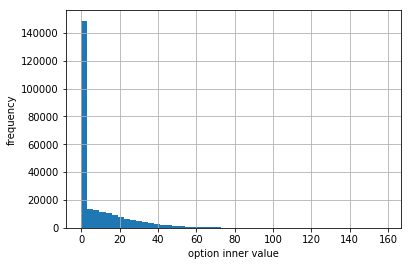

In [152]:
vector_MC_3()